# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import cv2

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [2]:
import torch.nn as nn
import torchvision.models as models
import torch.utils.model_zoo as model_zoo


class Resnet_Encoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers, pretrained, num_input_images=1):
        super(Resnet_Encoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        
        x = (input_image - 0.45) / 0.225
        print('input: ' + str(x.size()))
        
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        print('\nfeatures1: ' + str(self.features[-1].size()))
        
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        print('features2: ' + str(self.features[-1].size()))
        
        self.features.append(self.encoder.layer2(self.features[-1]))
        print('features3: ' + str(self.features[-1].size()))
        
        self.features.append(self.encoder.layer3(self.features[-1]))
        print('features4: ' + str(self.features[-1].size()))
        
        self.features.append(self.encoder.layer4(self.features[-1]))
        print('features5: ' + str(self.features[-1].size()))
        
        return self.features

In [3]:
from collections import OrderedDict
from layers import *


class Depth_Decoder(nn.Module):
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1, use_skips=True):
        super(Depth_Decoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips
        self.upsample_mode = 'nearest'
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # decoder
        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)

            # upconv_1
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            print('\nupconv1:   ' + str(x.size()))
            x = upsample(x)
            print('upsample:  ' + str(x.size()))
            x = [x]
            if self.use_skips and i > 0:
                print('features' + str(i) + ': ' + str(input_features[i - 1].size()))
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            print('cat_feat:  ' + str(x.size()))
            x = self.convs[("upconv", i, 1)](x)
            print('upconv2:   ' + str(x.size()))
            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))
                print('dispconv:  ' + str(self.outputs[("disp", i)].size()))

        return self.outputs

In [4]:
model_name = "flir_and_kaist_finetuned"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = Resnet_Encoder(18, False)
depth_decoder = Depth_Decoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')

# What's happening here?
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [6]:
#image_path = "assets/test_image.jpg"
#image_path = "assets/RGB_Flir_Test/FLIR_video_00006.jpg"
#image_path = 'assets/test_frames/0000000042.jpeg'
IR_image = "assets/IR_Flir_Test/FLIR_video_00038.jpeg"

input_image = pil.open(IR_image).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [7]:
print('width: {} height: {}'.format(original_width, original_height))

width: 640 height: 512


## Prediction using the PyTorch model

In [8]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

input: torch.Size([1, 3, 512, 640])

features1: torch.Size([1, 64, 256, 320])
features2: torch.Size([1, 64, 128, 160])
features3: torch.Size([1, 128, 64, 80])
features4: torch.Size([1, 256, 32, 40])
features5: torch.Size([1, 512, 16, 20])

upconv1:   torch.Size([1, 256, 16, 20])
upsample:  torch.Size([1, 256, 32, 40])
features4: torch.Size([1, 256, 32, 40])
cat_feat:  torch.Size([1, 512, 32, 40])
upconv2:   torch.Size([1, 256, 32, 40])

upconv1:   torch.Size([1, 128, 32, 40])
upsample:  torch.Size([1, 128, 64, 80])
features3: torch.Size([1, 128, 64, 80])
cat_feat:  torch.Size([1, 256, 64, 80])
upconv2:   torch.Size([1, 128, 64, 80])
dispconv:  torch.Size([1, 1, 64, 80])

upconv1:   torch.Size([1, 64, 64, 80])
upsample:  torch.Size([1, 64, 128, 160])
features2: torch.Size([1, 64, 128, 160])
cat_feat:  torch.Size([1, 128, 128, 160])
upconv2:   torch.Size([1, 64, 128, 160])
dispconv:  torch.Size([1, 1, 128, 160])

upconv1:   torch.Size([1, 32, 128, 160])
upsample:  torch.Size([1, 32, 256,

## Plotting

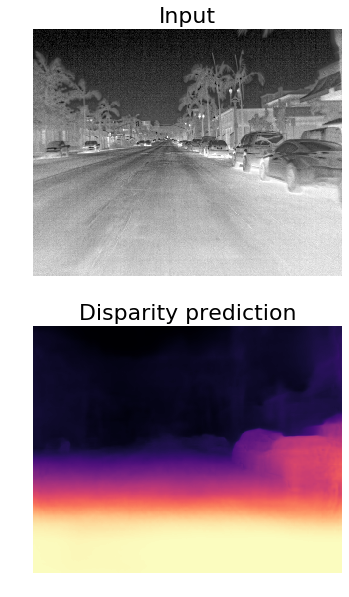

In [9]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
# Why computer q-th percentile?
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');